<a href="https://colab.research.google.com/github/gogilans/MSCI-546-Final-Project-/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L

Read Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Data Pre-Processing

In [4]:
train['Female'] = (train['Sex'] == 'female').astype('int64')
train.loc[train['Female'] <= 0.5]

train['Male'] = (train['Sex'] == 'male').astype('int64')
train.loc[train['Male'] > 0.5]

train['FirstClass'] = (train['Pclass'] == 1).astype('int64')

# Transforming the Sex into 0 and 1
#train['Sex'] = train['Sex'].map({'male': 0, 'female': 1}).astype(int)

# Rounding the Age
train['Age'].fillna(train['Age'].mean(), inplace = True)

#x=x.fillna(0)

y=train['Survived']
X=train[['Pclass','Age','Sex','Fare']] #removed ticket class and gender and cabin number


Data Analysis


Text(0, 0.5, 'Number of Passengers')

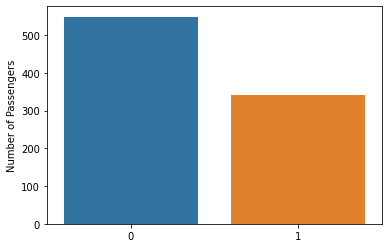

In [5]:
#data imbalance
sns.barplot(x = y.unique(), y = y.value_counts())
plt.ylabel('Number of Passengers')

   Pclass  Age  Sex  Fare
0     891  891  891   891


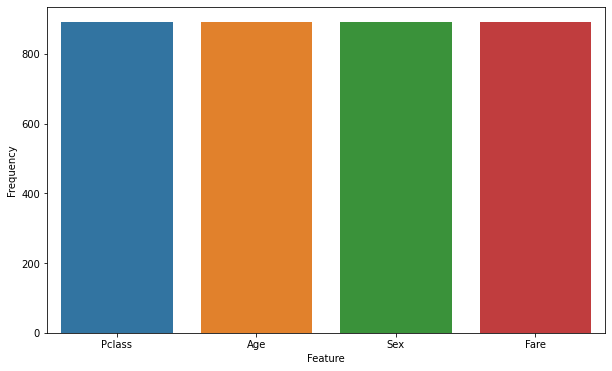

In [6]:
frequencies = X.count()

freq_df = pd.DataFrame([frequencies], columns=X.columns)
print(freq_df.head())

plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y = frequencies)
plt.ylabel('Frequency')
plt.xlabel('Feature')
plt.show()

In [7]:
#imputing and one-hot encoding
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())
])

#combine pipelines
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'Fare']
cat_attribs = ['Pclass', 'Sex',]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                   ("cat", cat_pipeline, cat_attribs)])
X = full_pipeline.fit_transform(X)
X.shape

#X.reshape(train, [897, 7])
#X.shape

#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

#random state - reproduces the same set of random values

In [ ]:
X_train.shape

(623, 7)

Neural Network

In [8]:
#Step 1
model = Sequential(name='titanic_model')

#Step 2
model.add(L.InputLayer(input_shape=(7,))) # necessary to use model.summary()

#Step 3
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(1024, activation='relu'))
model.add(L.Dropout(0.4)) #prevents overfitting by setting 40% of nuerons to 0
model.add(L.Dense(512, activation='relu'))
model.add(L.Dropout(0.4))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(1, activation='sigmoid')) # output layer, use sigmoid for binary

model.summary()


Model: "titanic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4096      
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)              

In [9]:
#Step 4
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.83):
            print("\nReached 83% accuracy so cancelling training!")
            self.model.stop_training = True


#Step 6
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=8, 
                    callbacks=[myCallback()],
                    epochs=10)

Epoch 1/10
78/78 [==============================] - 8s 47ms/step - loss: 0.6314 - accuracy: 0.6854 - val_loss: 0.5471 - val_accuracy: 0.7687
Epoch 2/10
78/78 [==============================] - 3s 34ms/step - loss: 0.4888 - accuracy: 0.7881 - val_loss: 0.4547 - val_accuracy: 0.7910
Epoch 3/10
78/78 [==============================] - 3s 43ms/step - loss: 0.4649 - accuracy: 0.7929 - val_loss: 0.4604 - val_accuracy: 0.7761
Epoch 4/10
78/78 [==============================] - 3s 43ms/step - loss: 0.4494 - accuracy: 0.8058 - val_loss: 0.4458 - val_accuracy: 0.7873
Epoch 5/10
78/78 [==============================] - 2s 25ms/step - loss: 0.4413 - accuracy: 0.8042 - val_loss: 0.4456 - val_accuracy: 0.7836
Epoch 6/10
78/78 [==============================] - 1s 18ms/step - loss: 0.4338 - accuracy: 0.8058 - val_loss: 0.4440 - val_accuracy: 0.7836
Epoch 7/10
78/78 [==============================] - 1s 18ms/step - loss: 0.4257 - accuracy: 0.8026 - val_loss: 0.4436 - val_accuracy: 0.8134
Epoch 8/10
78

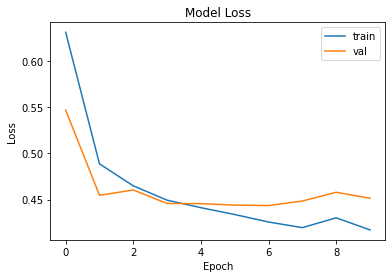

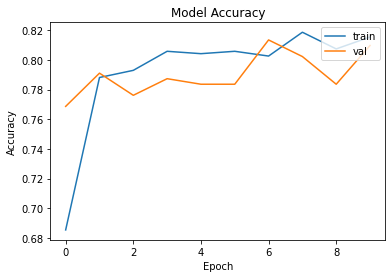

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [12]:
# split data
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# defining our tree object with the hyper parameters discussed above
model.evaluate(x_test,  y_test, verbose=2)

9/9 - 0s - loss: 0.3918 - accuracy: 0.8097 - 61ms/epoch - 7ms/step


[0.3918379843235016, 0.8097015023231506]